In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate a Time Series

In time series analysis, it is often assumed that a series can be decomposed as:

$$data = trend + seasonality + noise$$

To generate a synthetic series under this assumption:

## **White Noise**  
Generate a series of white noise: i.i.d. random variables drawn from a standard normal distribution: $\epsilon_t \sim N(0,1)$

## **AR($p$) Process**  
Construct an AR($p$) process driven by the generated white noise $\epsilon_t$.

$$X_t = \sum_{i = 1}^{p}\phi_iX_{t-i} + \epsilon_t$$

There are two equivalent formulations for the characteristic polynomial of an AR($p$) process—via the Z-transform or via the backshift operator.

1. **Z-transform**
   $$\mathcal{Z}\{X_t\}(1 - \sum_{i=1}^{p}\phi_i*z^{-i}) = \mathcal{Z}\{\epsilon_t\}, z\in\mathbb{C}$$
   where
   $$1 - \sum_{i=1}^{p}\phi_i*z^{-i} = 0$$
   defines the characteristic polynomial (a real-valued polynomial in $z$).
   - For the AR(p) process to be stationary, all solutions (roots) of the characteristic polynomial must lie outside of the unit circle $|z|>1$
   - If any roots are complex, they must occur in complex conjugate pairs, because the $\phi_i$ are real.
   - If $p$ is odd, at least one root is necessarily real.
    These conditions arise because $\{X_t\}$ is assumed to be a real-valued process, implying real coefficients $\phi_i$.
2. **Backshift operator**

   The backshift operator is defined as
   $$L^kX_t = X_{t-k}$$
   The AR(p) process equation can be rewritten as
   $$X_t(1-\sum_{i=1}^p\phi_iL^i) = \epsilon_t$$
   where $$1-\sum_{i=1}^p\phi_iL^i = 0$$
   is the same characteristic polynomial, with $L$ corresponding to $z^{-1}$ from the Z-transform approach.

### Generating an AR($p$) Process

To generate an AR($p$) process:

1. **Generate the roots ensuring stationarity**  
   Generate the roots $\{L_i\}_{i=1}^p$ of the polynomial in the backshift operator $L$,

2. **Compute AR Coefficients via Vieta’s Formulas**  
   Suppose the polynomial factors as

   $$\prod_{i=1}^p(1 - L_i L) = 1 - \phi_1 L - \phi_2 L^2 - \dots - \phi_p L^p$$

   By expanding the product on the left and matching coefficients term-by-term, we obtain Vieta’s relations for $\phi_i$:

   $$\phi_1 = \sum_{i=1}^p L_i,$$

   $$\phi_2 = -\sum_{1 \le i < j \le p} L_i L_j,$$

   $$\phi_3 = \sum_{1 \le i < j < k \le p} L_i L_j L_k,$$

   and so forth, alternating signs. In general,

   $$\phi_m = (-1)^m \sum_{1 \le i_1 < i_2 < \dots < i_m \le p} L_{i_1} L_{i_2} \dots L_{i_m}$$

3. **Simulate Data**
   - Given $\phi_1, \phi_2, \dots, \phi_p$ and a white noise process $\{\epsilon_t\}$, initialize $X_1, \dots, X_p$ to zeros.  
   - Compute
     $$X_t = \sum_{i=1}^p \phi_i X_{t-i} + \epsilon_t, \quad t = p+1, p+2, \dots$$
   - To obtain a time series of length $T$, generate $T+M$ data points and discard the first $M$ values to remove the influence of the initial zeros.  
   - $M$ is set to $10p$ to ensure minimal impact from initialization.

This procedure yields a stationary AR($p$) time series $\{X_t\}$.

## **Quadratic Trend**  
Add a quadratic trend that is “centered,” meaning its minimum (or maximum) is placed around the midpoint of the time series. This is done by shifting the time index $t$ so that $t = 0$ occurs near the center, thereby avoiding excessively large values at either end.

## **Seasonality (TODO)**  

This approach produces a synthetic time series with a specified trend, seasonality, and correlated noise structure.

## Time frame choice

In [34]:
# Y years of daily data
Y = 3
# My year temporarily has 10 days so it's easier to check
# TODO chage to 365
N = 10 * Y
start_date = pd.to_datetime("2020-01-01")
date_index = pd.date_range(start = start_date, periods = N, freq = 'D')
synth_ts = pd.DataFrame(index = date_index)

## White noise generation

In [35]:
rng = np.random.default_rng()

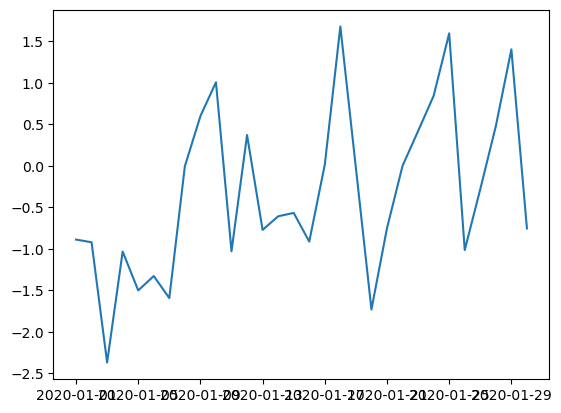

In [36]:
# Generate white noise
mu = 0
sigma = 1
synth_ts["noise"] = rng.normal(mu, sigma, size = N)
plt.plot(synth_ts["noise"])

## Stationary AR(p)

In [41]:
def generate_stationary_roots(p):
    """
    Generate p roots for the characteristic polynomial of an AR(p) process
    using the backshift operator approach (ensuring |L| < 1).
    """
    roots = []
    num_complex_pairs = p // 2  # Number of complex conjugate pairs
    num_real = p % 2  # If p is odd, we need one real root

    # Set small lower bound to avoid trivial terms
    lower_bound = 1e-8  

    # Generate complex roots in conjugate pairs
    for _ in range(num_complex_pairs):
        r = rng.uniform(lower_bound, 1)  # Generate length. Ensure |L| < 1
        #r = rng.uniform(1, 10)
        theta = rng.uniform(0, np.pi)  # Random angle for complex number
        complex_root = r * np.exp(1j * theta)  # Convert to complex form
        roots.append(complex_root)
        roots.append(np.conj(complex_root))  # Add conjugate pair

    # If p is odd, add a real root
    if num_real == 1:
        real_root = rng.uniform(lower_bound, 1)  # Ensure |L| < 1
        roots.append(real_root)

    return np.array(roots)

In [63]:
from numpy.polynomial import Polynomial as P

# This thing somehow treats roots like they are in z-space and generates coefficients accordingly.

def compute_ar_coefficients(roots):
    """
    Compute AR(p) coefficients from the given roots.
    """
    # Get polynomial coefficients from roots
    p = P.fromroots(roots)  # Returns c_0 + c_1*L + c_2*L^2 + ...
    poly_coeffs = p.coef

    # Extract AR coefficients
    # Divide all coefficients by c_0, so it's 1 + alpha_1*L + alpha_2*L + ...
    phi = poly_coeffs/poly_coeffs[0]

    # phi_i = -alpha_i
    # returns as complex numbers, later can be checked if the imaginary part
    # is 0 if a real valued process required
    return -phi[1:]

In [74]:
import numpy as np

def generate_ar_process(ar_params, T, burnin_factor = 10, sigma = 1.0, random_seed = None):
    """
    Generate a synthetic AR(p) time series of length T using the given coefficients.
    
    Parameters
    ----------
    ar_params : array-like
        AR coefficients, e.g. [a1, a2, ..., ap] for AR(p).
        The model is X_t = sum_{k=1..p} a_k * X_{t-k} + e_t
    T : int
        Number of output samples desired for the AR(p) process.
    burnin_factor : int, optional
        How many multiples of p to use as burn-in. Defaults to 10.
    sigma : float, optional
        Standard deviation of the white noise. Defaults to 1.0.
    random_seed : int, optional
        Seed for the random number generator (for reproducibility).

    Returns
    -------
    x : ndarray
        A 1D numpy array of length T containing the generated AR(p) process.
    noise: ndarray
        Noise used to generate the synthetic process.
    """

    rng = np.random.default_rng(random_seed)
    
    p = len(ar_params)               # order p
    burnin = burnin_factor * p       # number of burn-in samples
    
    # Total samples to generate (including burn-in)
    total_length = T + burnin
    
    # Allocate array for the AR process
    x = np.zeros(total_length)
    
    # Generate white noise
    noise = rng.normal(loc = 0.0, scale = sigma, size = total_length)
    
    # AR(p): X[t] = a1*X[t-1] + ... + ap*X[t-p] + noise[t]
    # Start from t = p up to total_length-1
    for t in range(p, total_length):
        # Sum the influence of the previous p samples
        for k in range(1, p+1):
            x[t] += 1/ar_params[k-1] * x[t-k]
        # Add noise
        x[t] += noise[t]
    
    # Discard the burn-in samples
    return x[burnin:], noise

In [75]:
# Example: Generate stationary roots for AR(p)
p = 3
roots = generate_stationary_roots(p)
print("Generated stationary roots (should be inside unit circle):", roots)
print("Magnitudes of roots:", np.abs(roots))

Generated stationary roots (should be inside unit circle): [0.54101755+0.53181604j 0.54101755-0.53181604j 0.22896583+0.j        ]
Magnitudes of roots: [0.7586358  0.7586358  0.22896583]


In [76]:
print(roots)
ar_coef = compute_ar_coefficients(roots)
ar_coef

[0.54101755+0.53181604j 0.54101755-0.53181604j 0.22896583+0.j        ]


array([ 6.24753674-1.05313221e-16j, -9.94868434+0.00000000e+00j,
        7.58861734+0.00000000e+00j])

In [77]:
print(ar_coef)
x, noise = generate_ar_process(ar_coef.real, 1000)

[ 6.24753674-1.05313221e-16j -9.94868434+0.00000000e+00j
  7.58861734+0.00000000e+00j]


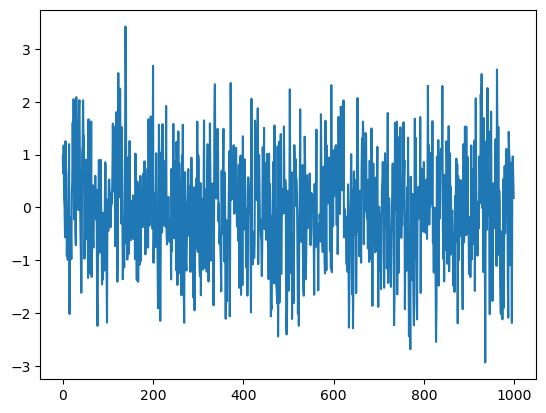

In [78]:
plt.plot(x)

## Trend

In [49]:
# Generate a trend
if N % 2 == 0:
    adj_to_center = N/2
else:
    adj_to_center = (N - 1)/2
synth_ts["t"] = np.arange(N) - adj_to_center
synth_ts["t2"] = synth_ts["t"]**2

In [50]:
synth_ts

,noise,t,t2
2020-01-01,-0.952578,-15.0,225.0
2020-01-02,0.357504,-14.0,196.0
2020-01-03,1.687633,-13.0,169.0
2020-01-04,0.264103,-12.0,144.0
2020-01-05,2.673997,-11.0,121.0
2020-01-06,-0.481717,-10.0,100.0
2020-01-07,-0.542504,-9.0,81.0
2020-01-08,-0.637542,-8.0,64.0
2020-01-09,0.178654,-7.0,49.0
2020-01-10,-0.983914,-6.0,36.0
